# Exercise 17: Regularized regression

This homework assignment is designed to give you an intuition as an interesting property of regularization in the context of ultra-high dimensional statistical problems.

You won't need to load in any data for this homework.

---
## 1. Simulating & visualizing data (2 points)

We are going to be looking at what happens in the context where $p>n$. In order to have total control over our data, we will use simulations for this homework. First, we will need to load the `glmnet`, `tidyverse`, and `ggplot2` libraries for this assignment.


In [1]:
install.packages("glmnet", dependencies = TRUE) # uncomment if you haven't installed this library
library(glmnet)
library(tidyverse)
library(ggplot2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’, ‘lars’


Loading required package: Matrix

Loaded glmnet 4.1-8

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


We are going to generate a data set with complex structure and try to recover it using polynomial models. For simplicity sake, use the following code to produce a response variable, $y$ that has complex structure.

*Hint: Look up what a cosine function looks like if you need a reminder.*

In [2]:
# Generate data
set.seed(121)
sigma_noise = .5
x=seq(-9,9,by=.18)
n=length(x)
y = 0.1*x + cos(x) + cos(x/20)+rnorm(n,sd=sigma_noise)

(a) Break the data into a training set (n=50) and test set (n=51) using the `sample` function to randomly select subsets of x and y.  Make a separate data frame for the training and test data.

(**Note**: *Do not* just take the first 50 observations to be the training set and last 51 observations to be the test set.)

In [3]:
set.seed(121) # Use the same seed so we get the same results


train_indices = sample(seq(n), 50, replace = FALSE)
test_indices = setdiff(1:n, train_indices)

trainX = x[train_indices]
trainY = y[train_indices]
testX = x[-train_indices]
testY = y[-train_indices]

train_data = data.frame(x = trainX, y = trainY)
test_data = data.frame(x = testX, y = testY)

head(train_data)
head(test_data)

,x,y
,<dbl>,<dbl>
1,0.18,0.9768865
2,-4.14,-0.5463294
3,-7.02,0.5469083
4,3.60,0.9704096
5,-8.46,-0.5442746
6,3.96,0.7313249


,x,y
,<dbl>,<dbl>
1,-8.82,-0.74611573
2,-8.64,-0.59952472
3,-8.28,-0.68257115
4,-7.92,0.21327419
5,-7.56,-0.08663415
6,-7.38,1.10789561




```

```

(b) Plot the training data ($x$ \& $y$). Describe the relationship that you see in the training data.

`geom_smooth()` using formula = 'y ~ x'


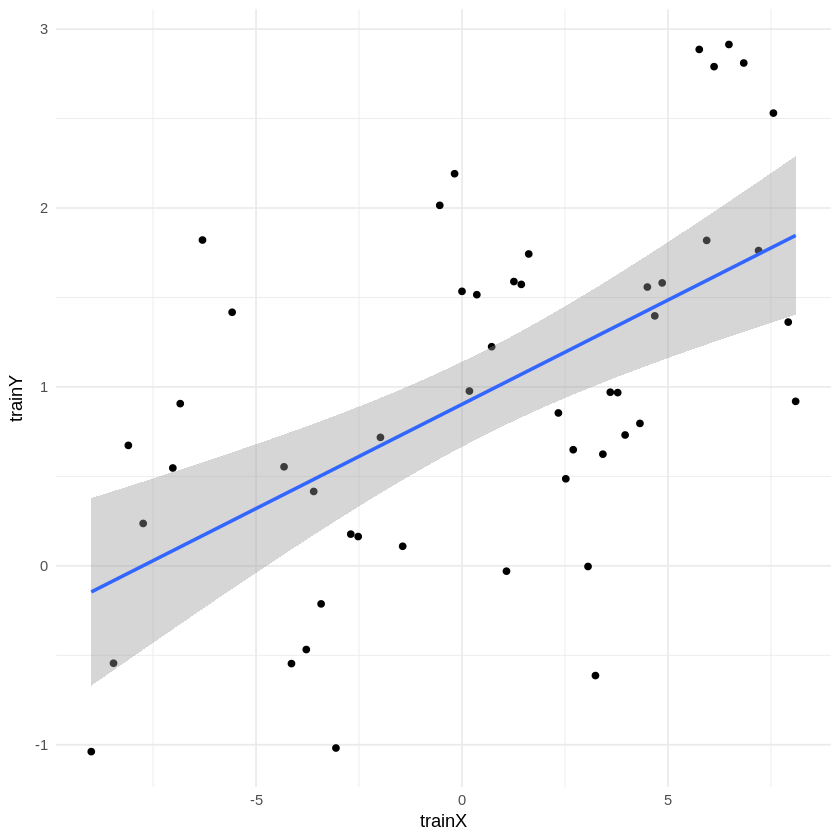

In [16]:
ggplot(train_data, aes(x = trainX, y = trainY)) +
  geom_point() +
    geom_smooth(method = 'lm')+
    theme_minimal()


How would you describe the relationship between $x$ and $y$ based on this plot?

> There is a positive relationship based on the linear regression line but the points are not fitted well to it
>

---
## 2. Bias-variance tradeoff: polynomial regression (4 points)

Recall that in polynomial regression we increase model complexity by expanding $x$ out to the power $k$ (which we call degree).


$$Y = \hat{\beta}_0 + \sum_{j=1}^K \hat{\beta}_jX^j $$  

$$ = poly(x,k)$$

(a) Fit a 2nd degree polynomial regression model to the training data. Plot the results.


*Hint: Use the* `help` *function to see how to use the* `stat_smooth()` *and* `poly()` *functions.*

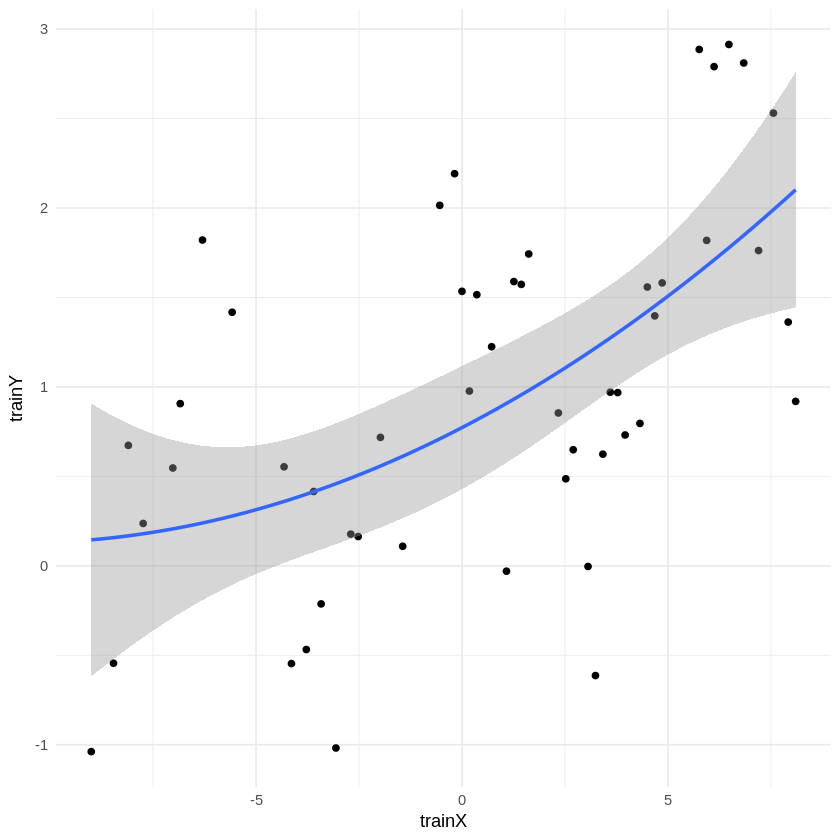

In [15]:
ggplot(train_data, aes(x = trainX, y = trainY)) +
  geom_point() +
    stat_smooth(method = 'lm', formula = y ~ poly(x, 2)) +
    theme_minimal()


How well does this 2nd degree polynomial model qualitatively fit the data? Could it do better?

> The data points are represented better by the regression line, it does better than before but it could do better than this.
>

(b) Fit a 12th degree polynomial to the data. Does this do qualitatively better or worse than the 2nd degree model?

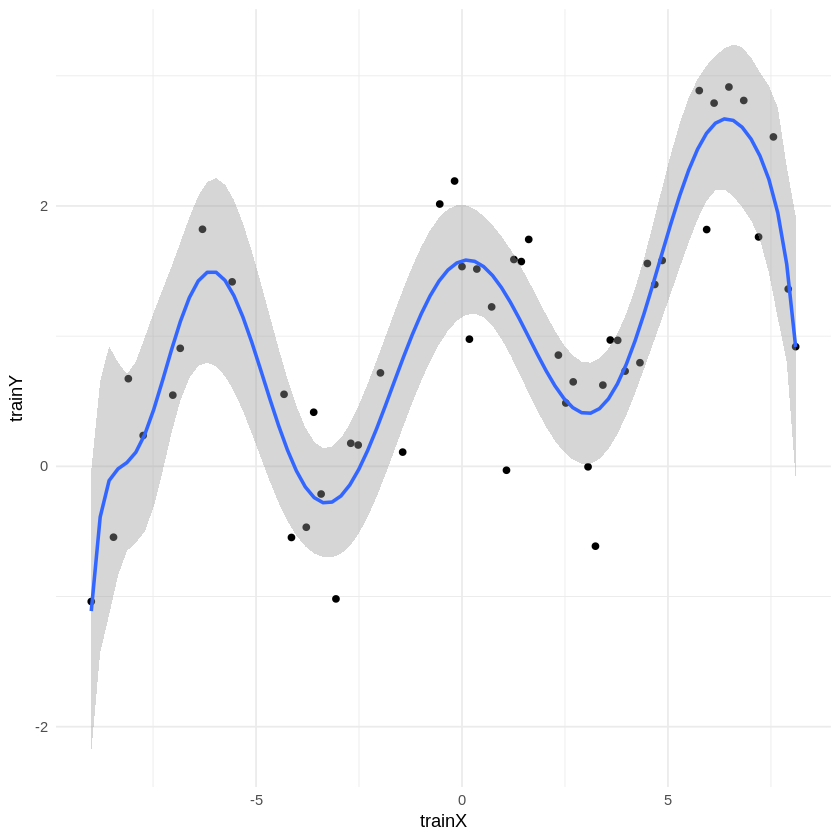

In [14]:
ggplot(train_data, aes(x = trainX, y = trainY)) +
  geom_point() +
    stat_smooth(method = 'lm', formula = y ~ poly(x, 12)) +
    theme_minimal()



> This is better than the second degree because it waves with the data points and they are fitted around the line

(c) Modify the loop below to estimate the bias-variance tradeoff as model complexity (i.e., degree of the polynomial model, $k$) increases from 2 to 50. Use the training data to fit the model and test data to evaluate its predictive accuracy.

Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree.


(**Note**: We are using median accuracies here because there are often 1 or 2 outlier values in the higher degree polynomial models that can throw off the accuracy estimates).

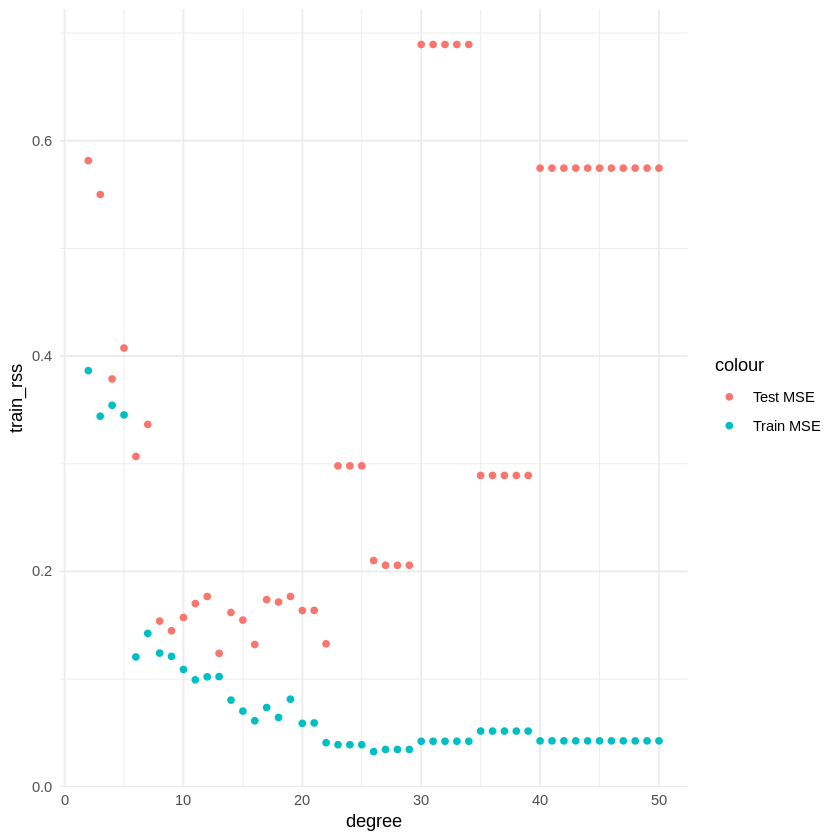

In [39]:
# Now do the variance-bias trade off analysis using regular regression
degree = seq(2,50)

# Need to setup your output vectors
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)

for (k in degree) {
  model <- lm(y ~ poly(x, k, raw = TRUE), data = train_data)

  train_pred <- predict(model, newdata = train_data)
  train_rss[k-1] <- median((train_data$y - train_pred)^2)

  # Predictions on test data
  test_pred <- predict(model, newdata = test_data)
  test_rss[k-1] <- median((test_data$y - test_pred)^2)
}


# Plot your results here
results = data.frame(
degree,
train_rss,
test_rss
)

ggplot(results, aes(x = degree)) +
  geom_point(aes(y = train_rss, color = 'Train MSE')) +
  geom_point(aes(y = test_rss, color = 'Test MSE')) +
  theme_minimal()

What do you see as $k$ increase?

> increase in k increases model fit for training, but increasing k for test data too much creates high bias in the data and the best point is in the middle range

(d) Now copy the code above and let's see what happens when we go beyond $p=n$ (remember, in this case $k=p$). Test polynomial models up to $k=150$. Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree.

Use the `geom_vline()` function in `ggplot` to draw a vertical line where $k=n$ (here $n$ is the number of observations in the training set). This will make it clear where we cross the threshold for finding *unique* solutions in our data.



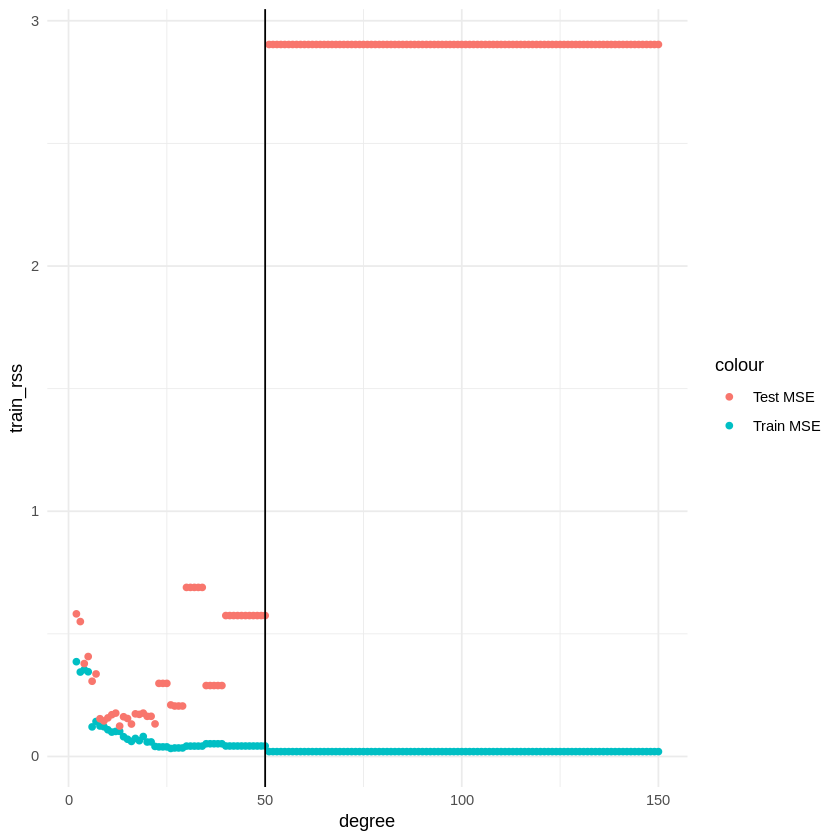

In [40]:
degree = 2:150

train_rss = matrix(data = NA, nrow = length(degree), ncol = 1)
test_rss = matrix(data = NA, nrow = length(degree), ncol = 1)

for (k in degree) {
  model <- lm(y ~ poly(x, k, raw = TRUE), data = train_data)

  train_pred <- predict(model, newdata = train_data)
  train_rss[k - 1] <- median((train_data$y - train_pred)^2)

  test_pred <- predict(model, newdata = test_data)
  test_rss[k - 1] <- median((test_data$y - test_pred)^2)
}

results = data.frame(
  degree = degree,
  train_rss = train_rss,
  test_rss = test_rss
)

n_train = nrow(train_data)

ggplot(results, aes(x = degree)) +
  geom_point(aes(y = train_rss, color = 'Train MSE')) +
  geom_point(aes(y = test_rss, color = 'Test MSE')) +
  geom_vline(xintercept = n_train) +
  theme_minimal()

What do you see as $k$ gets larger than $n$?

> When k gets larger than n, test error increases too much and generalizes poorly to new data.
>

---
## 3. Applying regularization to the model fits (2 points)

Repeat the previous bias-variance tradeoff test, going up to $k=150$, but now use ridge regression with a sparsity parameter of $\lambda=0.00005$. Plot your results the same way as last time.

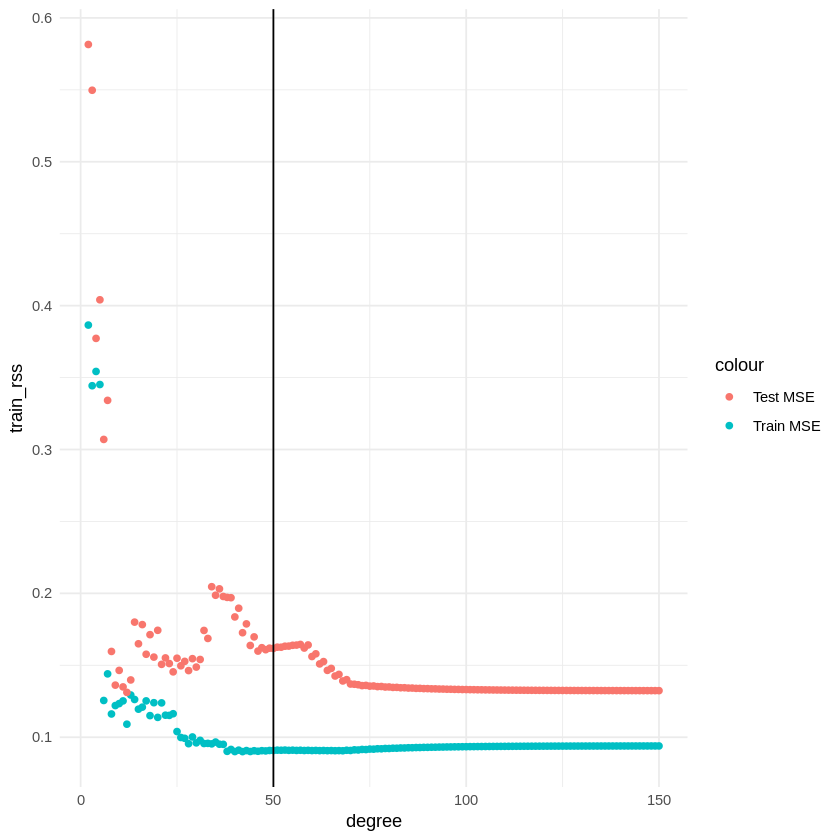

In [41]:
# Now do the variance-bias trade off analysis using ridge regression
lambda=0.00005
degree = seq(2,150)

rm(train_rss, test_rss)
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)

for (k in degree) {
    # WRITE YOUR CODE HERE
X_train <- as.matrix(sapply(1:k, function(j) train_data$x^j))
X_test  <- as.matrix(sapply(1:k, function(j) test_data$x^j))

ridge_model <- glmnet(X_train, train_data$y, alpha = 0, lambda = lambda, standardize = FALSE)

train_pred <- predict(ridge_model, newx = X_train)
test_pred  <- predict(ridge_model, newx = X_test)

train_rss[k - 1] <- median((train_data$y - train_pred)^2)
test_rss[k - 1]  <- median((test_data$y - test_pred)^2)

}

results = data.frame(
  degree = degree,
  train_rss = train_rss,
  test_rss = test_rss
)

# Plot your results here
ggplot(results, aes(x = degree)) +
  geom_point(aes(y = train_rss, color = 'Train MSE')) +
  geom_point(aes(y = test_rss, color = 'Test MSE')) +
  geom_vline(xintercept = n_train) +
  theme_minimal()


What happens now when $k$ gets larger than $n$?

> Error decreases then eventually plateaus.
>

---
## 4. Reflection (2 points)

The simulations above should have shown that, when applying a regularization (i.e., a sparsity constraint), the behavior of the bias-variance tradeoff changes. Explain why this happens.

> Regularization penalizes larger coefficients and shrinks them close to zero, therefore the model is less flexible and less generalizible. That also introduces bias.
>

---
## Bonus (1 extra credit point)
Recall that the $p=n$ threshold defines the limit for finding a *unique* solution to $Y=F(X)$ (i.e., there is only one combination of regression coefficients that is *best* at explaining variance in $Y$). With this in mind, what is regularization doing that works around this upper limit?

> It not only minimizes error but it penalizes large coefficients and prefers simpler terms (small and stable values )which therefore decreases noise.
>

**DUE:** 5pm EST, April 10, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*